## 模型训练及调参
### 数据集划分：按时间维度，将train.csv中最后六周划为验证集，检验模型对未来六周对预测准确度；

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from scipy import stats
import datetime
import random
from sklearn.utils import shuffle

/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
all_df = pd.read_csv("model_data0317_ext.csv")
all_df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SalesLog,SchoolHoliday,Set,...,avgsal_last3m,avgsal_last6m,avgsal_mblm,avgsal_percustomer,avgsal_std,daysFromLastSchHol,daysFromLastStateHol,daysToNextSchHol,daysToNextStateHol,Outlier
0,678.0,2013-03-02,6,NaN,1.0,0,5350.0,8.585039,0,1,...,8.530299,8.530299,8.505253,8.155622,6.696062,50.0,60.0,23.0,27.0,0
1,840.0,2013-03-04,1,NaN,1.0,1,7675.0,8.945854,0,1,...,8.531381,8.531381,8.505253,8.150073,6.687390,52.0,62.0,21.0,25.0,1
2,715.0,2013-03-05,2,NaN,1.0,1,6300.0,8.748464,0,1,...,8.541024,8.541024,8.505253,8.175047,6.770112,53.0,63.0,20.0,24.0,0
3,678.0,2013-03-06,3,NaN,1.0,1,5973.0,8.695172,0,1,...,8.545284,8.545284,8.505253,8.188462,6.777641,54.0,64.0,19.0,23.0,0
4,702.0,2013-03-07,4,NaN,1.0,1,5637.0,8.637285,0,1,...,8.548220,8.548220,8.505253,8.200642,6.776555,55.0,65.0,18.0,22.0,0


In [3]:
all_df['Date'] = pd.to_datetime(all_df['Date'])
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639411 entries, 0 to 639410
Data columns (total 58 columns):
Customers                    598323 non-null float64
Date                         639411 non-null datetime64[ns]
DayOfWeek                    639411 non-null int64
Id                           41088 non-null float64
Open                         639411 non-null float64
Promo                        639411 non-null int64
Sales                        598323 non-null float64
SalesLog                     598323 non-null float64
SchoolHoliday                639411 non-null int64
Set                          639411 non-null int64
StateHoliday                 639411 non-null int64
Store                        639411 non-null int64
Year                         639411 non-null int64
MonthofYear                  639411 non-null int64
WeekofYear                   639411 non-null int64
DayofMonth                   639411 non-null int64
DayofYear                    639411 non-null int64
Date

-----
### 定义评估函数 rmspe

In [4]:
def rmspe(y, yhat):
    # rmspe 计算
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    # xgboost 中对 rmspe 参数赋值
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

def exp_transform(x):
    return np.expm1(x)

In [5]:
y_col = 'SalesLog'
x_cols =  [ 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday', 'Store',
            'MonthofYear', 'WeekofYear', 'DayofMonth', 'DayofYear', 'DateInt',
            'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',
            'Promo2SinceFloat', 'CompetitionOpenInt', 'sal_avg',
            'sal_avg_percustomer', 'sal_avg_promo', 'sal_avg_schoolhol',
            'sal_avg_statehol', 'sal_avg_std', 'CompetitionLastMonths',
            'inCompetition', 'Promo2LastMonths', 'Promo2_Month', 'inPromo2',
            'PromoIntervalType', 'avgsal', 'avgsal_curryear', 'avgsal_dayofmonth',
            'avgsal_dayofmonth_res', 'avgsal_dayofweek', 'avgsal_dayofweek_res',
            'avgsal_dayofyear', 'avgsal_last3m', 'avgsal_last6m', 'avgsal_mblm',
            'avgsal_percustomer', 'avgsal_std', 'daysFromLastSchHol',
            'daysFromLastStateHol', 'daysToNextSchHol', 'daysToNextStateHol']
train_data = all_df[(all_df['Set']==1) & (all_df['Outlier']==0)] #[x_cols+[y_col]]

test_data = all_df[all_df['Set']==2].sort_values('Id')
#test_data = all_df[all_df['Set']==2]#[x_cols+[y_col]]
print(len(train_data))

586890


-----
### 按时间维度划分数据集，将带有标签的最后六周数据单独提取，作为验证集

In [6]:
tr_data = train_data[train_data['Date'] < pd.to_datetime('2015-06-19')].sample(frac=1,random_state=10)
#tr_data = shuffle(tr_data)
X_train = tr_data[x_cols]
y_train = tr_data[y_col]
te_data = train_data[train_data['Date'] >= pd.to_datetime('2015-06-19')].sample(frac=1,random_state=10)
#te_data = shuffle(te_data)
X_test = te_data[x_cols]
y_test = te_data[y_col]

len(y_train),len(y_test)

(555665, 31225)

In [7]:
X_train.head()

,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Store,MonthofYear,WeekofYear,DayofMonth,DayofYear,...,avgsal_dayofyear,avgsal_last3m,avgsal_last6m,avgsal_mblm,avgsal_percustomer,avgsal_std,daysFromLastSchHol,daysFromLastStateHol,daysToNextSchHol,daysToNextStateHol
327457,1,1.0,0,0,0,566,2,9,23,54,...,8.102586,8.656725,8.591817,8.753315,8.839521,7.086488,48.0,53.0,7.0,39.0
450979,4,1.0,1,0,0,778,1,2,9,9,...,8.900958,8.766009,8.731766,8.732543,7.360213,7.316262,6.0,3.0,53.0,99.0
77779,4,1.0,0,0,0,141,6,26,27,178,...,NaN,8.592523,8.603607,8.580438,9.023040,7.233854,27.0,28.0,28.0,98.0
348295,1,1.0,0,0,0,601,5,22,26,146,...,NaN,8.495453,8.529783,8.489450,12.078054,7.071447,31.0,25.0,63.0,3.0
232387,4,1.0,1,0,0,406,9,38,18,261,...,8.150179,8.761585,8.771563,8.774302,12.579017,7.316125,13.0,91.0,32.0,15.0


-----
### 定义网格搜索函数，用来确定模型的最优参数

In [8]:
def tune_gridsearch(model,param_dict,X_train, y_train,X_train1, y_train1,X_test, y_test):
    clf = GridSearchCV(model,
                       param_dict,
                       n_jobs=36,
                       iid=False,
                       cv=5,
                       verbose=1
                      )
    clf.fit(X_train,y_train)
    xgb_best = clf.best_estimator_
    
    print("xgb train rmspe: %.4f" % rmspe(exp_transform(y_train),exp_transform(xgb_best.predict(X_train))))
    print("xgb train1 rmspe: %.4f" % rmspe(exp_transform(y_train1),exp_transform(xgb_best.predict(X_train1))))
    print("xgb test rmspe: %.4f" % rmspe(exp_transform(y_test),exp_transform(xgb_best.predict(X_test))))
    display(clf.grid_scores_)
    print(clf.best_params_)
    print(clf.best_score_)
    return clf.best_estimator_

#from sklearn.metrics import mean_squared_error

-----
### 因数据量大，时间原因，仅抽样少量数据进行网格搜索

In [9]:
sample_data = tr_data.sample(frac=0.1,random_state=10)
X_sample = sample_data[x_cols]
y_sample = sample_data[y_col]

In [10]:
X_sample.head()

,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday,Store,MonthofYear,WeekofYear,DayofMonth,DayofYear,...,avgsal_dayofyear,avgsal_last3m,avgsal_last6m,avgsal_mblm,avgsal_percustomer,avgsal_std,daysFromLastSchHol,daysFromLastStateHol,daysToNextSchHol,daysToNextStateHol
466330,3,1.0,0,0,0,809,6,26,26,177,...,NaN,9.140190,9.127803,9.102737,11.468543,7.949613,36.0,27.0,26.0,99.0
601856,1,1.0,0,0,0,1053,3,11,11,70,...,NaN,9.050785,9.050785,8.998008,8.641178,7.791340,38.0,69.0,7.0,18.0
484581,6,1.0,0,0,0,846,5,19,10,130,...,9.268326,9.122373,9.146648,9.103106,10.430629,7.923133,15.0,9.0,31.0,19.0
386395,1,1.0,1,0,0,670,6,25,15,166,...,8.520388,8.830520,8.811433,8.854588,9.388245,7.349286,10.0,11.0,49.0,61.0
60820,5,1.0,1,1,0,109,4,16,17,107,...,8.808444,8.787188,8.840817,8.778223,8.686314,7.307097,1.0,11.0,28.0,14.0


-----
### 开始网格搜索，主要优化参数：
* max_depth
* min_child_weight
* gamma
* subsample
* colsample_bytree
* reg_lambda
* reg_alpha

In [11]:
xgb_model = XGBRegressor(random_state=10)
param_dict = {'max_depth':np.arange(6,20,2),
              'min_child_weight':np.arange(3,21,2)}
best_model = tune_gridsearch(xgb_model,param_dict,X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:  1.2min
[Parallel(n_jobs=36)]: Done 315 out of 315 | elapsed:  3.9min finished


xgb train rmspe: 0.0540
xgb train1 rmspe: 0.1001
xgb test rmspe: 0.1145


[mean: 0.92595, std: 0.00217, params: {'max_depth': 6, 'min_child_weight': 3},
 mean: 0.92573, std: 0.00162, params: {'max_depth': 6, 'min_child_weight': 5},
 mean: 0.92564, std: 0.00196, params: {'max_depth': 6, 'min_child_weight': 7},
 mean: 0.92582, std: 0.00184, params: {'max_depth': 6, 'min_child_weight': 9},
 mean: 0.92565, std: 0.00159, params: {'max_depth': 6, 'min_child_weight': 11},
 mean: 0.92501, std: 0.00167, params: {'max_depth': 6, 'min_child_weight': 13},
 mean: 0.92496, std: 0.00192, params: {'max_depth': 6, 'min_child_weight': 15},
 mean: 0.92487, std: 0.00175, params: {'max_depth': 6, 'min_child_weight': 17},
 mean: 0.92476, std: 0.00194, params: {'max_depth': 6, 'min_child_weight': 19},
 mean: 0.93230, std: 0.00146, params: {'max_depth': 8, 'min_child_weight': 3},
 mean: 0.93237, std: 0.00165, params: {'max_depth': 8, 'min_child_weight': 5},
 mean: 0.93265, std: 0.00159, params: {'max_depth': 8, 'min_child_weight': 7},
 mean: 0.93241, std: 0.00136, params: {'max_dep

{'max_depth': 14, 'min_child_weight': 9}
0.9371775948361701


In [12]:
xgb_model = XGBRegressor(random_state=10)
param_dict = {'max_depth':[12,13,14,15],
              'min_child_weight':[8,9,10]}
best_model = tune_gridsearch(best_model,param_dict, X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=36)]: Done  50 out of  60 | elapsed:   59.8s remaining:   12.0s
[Parallel(n_jobs=36)]: Done  60 out of  60 | elapsed:  1.0min finished


xgb train rmspe: 0.0580
xgb train1 rmspe: 0.1000
xgb test rmspe: 0.1172


[mean: 0.93655, std: 0.00139, params: {'max_depth': 12, 'min_child_weight': 8},
 mean: 0.93649, std: 0.00163, params: {'max_depth': 12, 'min_child_weight': 9},
 mean: 0.93651, std: 0.00136, params: {'max_depth': 12, 'min_child_weight': 10},
 mean: 0.93716, std: 0.00110, params: {'max_depth': 13, 'min_child_weight': 8},
 mean: 0.93720, std: 0.00113, params: {'max_depth': 13, 'min_child_weight': 9},
 mean: 0.93670, std: 0.00144, params: {'max_depth': 13, 'min_child_weight': 10},
 mean: 0.93707, std: 0.00124, params: {'max_depth': 14, 'min_child_weight': 8},
 mean: 0.93718, std: 0.00136, params: {'max_depth': 14, 'min_child_weight': 9},
 mean: 0.93667, std: 0.00143, params: {'max_depth': 14, 'min_child_weight': 10},
 mean: 0.93703, std: 0.00141, params: {'max_depth': 15, 'min_child_weight': 8},
 mean: 0.93670, std: 0.00122, params: {'max_depth': 15, 'min_child_weight': 9},
 mean: 0.93700, std: 0.00154, params: {'max_depth': 15, 'min_child_weight': 10}]

{'max_depth': 13, 'min_child_weight': 9}
0.9371985442850047


In [13]:
param_dict = {'gamma':[i/10.0 for i in range(0,11)]}
best_model = tune_gridsearch(best_model,param_dict, X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=36)]: Done  40 out of  55 | elapsed:   55.7s remaining:   20.9s
[Parallel(n_jobs=36)]: Done  55 out of  55 | elapsed:   59.5s finished


xgb train rmspe: 0.0580
xgb train1 rmspe: 0.1000
xgb test rmspe: 0.1172


[mean: 0.93720, std: 0.00113, params: {'gamma': 0.0},
 mean: 0.93477, std: 0.00158, params: {'gamma': 0.1},
 mean: 0.93165, std: 0.00177, params: {'gamma': 0.2},
 mean: 0.92855, std: 0.00169, params: {'gamma': 0.3},
 mean: 0.92641, std: 0.00152, params: {'gamma': 0.4},
 mean: 0.92323, std: 0.00169, params: {'gamma': 0.5},
 mean: 0.92166, std: 0.00231, params: {'gamma': 0.6},
 mean: 0.92028, std: 0.00169, params: {'gamma': 0.7},
 mean: 0.91859, std: 0.00261, params: {'gamma': 0.8},
 mean: 0.91633, std: 0.00206, params: {'gamma': 0.9},
 mean: 0.91530, std: 0.00254, params: {'gamma': 1.0}]

{'gamma': 0.0}
0.9371985442850047


In [14]:
param_dict = {'subsample':[i/10.0 for i in range(5,10)],
              'colsample_bytree':[i/10.0 for i in range(5,10)]}
best_model = tune_gridsearch(best_model,param_dict, X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=36)]: Done 125 out of 125 | elapsed:  1.4min finished


xgb train rmspe: 0.0549
xgb train1 rmspe: 0.0987
xgb test rmspe: 0.1180


[mean: 0.93438, std: 0.00154, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
 mean: 0.93526, std: 0.00149, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
 mean: 0.93624, std: 0.00181, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
 mean: 0.93725, std: 0.00139, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
 mean: 0.93751, std: 0.00165, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
 mean: 0.93477, std: 0.00165, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
 mean: 0.93583, std: 0.00191, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
 mean: 0.93660, std: 0.00150, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
 mean: 0.93744, std: 0.00171, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
 mean: 0.93761, std: 0.00163, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
 mean: 0.93435, std: 0.00137, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
 mean: 0.93522, std: 0.00124, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
 mea

{'colsample_bytree': 0.6, 'subsample': 0.9}
0.9376090281250058


In [15]:
param_dict = {'subsample':[i/100.0 for i in range(85,100,5)],
              'colsample_bytree':[i/100.0 for i in range(55,70,5)]}
best_model = tune_gridsearch(best_model,param_dict, X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=36)]: Done  20 out of  45 | elapsed:   20.2s remaining:   25.3s
[Parallel(n_jobs=36)]: Done  45 out of  45 | elapsed:   37.4s finished


xgb train rmspe: 0.0541
xgb train1 rmspe: 0.0986
xgb test rmspe: 0.1172


[mean: 0.93702, std: 0.00146, params: {'colsample_bytree': 0.55, 'subsample': 0.85},
 mean: 0.93733, std: 0.00132, params: {'colsample_bytree': 0.55, 'subsample': 0.9},
 mean: 0.93793, std: 0.00149, params: {'colsample_bytree': 0.55, 'subsample': 0.95},
 mean: 0.93763, std: 0.00163, params: {'colsample_bytree': 0.6, 'subsample': 0.85},
 mean: 0.93761, std: 0.00163, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
 mean: 0.93805, std: 0.00159, params: {'colsample_bytree': 0.6, 'subsample': 0.95},
 mean: 0.93738, std: 0.00176, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
 mean: 0.93729, std: 0.00155, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
 mean: 0.93772, std: 0.00188, params: {'colsample_bytree': 0.65, 'subsample': 0.95}]

{'colsample_bytree': 0.6, 'subsample': 0.95}
0.9380549998540099


In [16]:
param_dict = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_model = tune_gridsearch(best_model,param_dict, X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=36)]: Done   6 out of  25 | elapsed:   19.4s remaining:  1.0min
[Parallel(n_jobs=36)]: Done  25 out of  25 | elapsed:   20.4s finished


xgb train rmspe: 0.0534
xgb train1 rmspe: 0.0985
xgb test rmspe: 0.1174


[mean: 0.93808, std: 0.00154, params: {'reg_alpha': 1e-05},
 mean: 0.93815, std: 0.00131, params: {'reg_alpha': 0.01},
 mean: 0.93802, std: 0.00156, params: {'reg_alpha': 0.1},
 mean: 0.93656, std: 0.00125, params: {'reg_alpha': 1},
 mean: 0.88880, std: 0.00193, params: {'reg_alpha': 100}]

{'reg_alpha': 0.01}
0.9381451185237036


In [17]:
param_dict = {'reg_alpha':[0,0.0001,0.001,0.005,0.01,0.02,0.05]}
best_model = tune_gridsearch(best_model,param_dict, X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=36)]: Done  35 out of  35 | elapsed:   22.8s finished


xgb train rmspe: 0.0536
xgb train1 rmspe: 0.0988
xgb test rmspe: 0.1177


[mean: 0.93805, std: 0.00159, params: {'reg_alpha': 0},
 mean: 0.93819, std: 0.00174, params: {'reg_alpha': 0.0001},
 mean: 0.93805, std: 0.00166, params: {'reg_alpha': 0.001},
 mean: 0.93840, std: 0.00155, params: {'reg_alpha': 0.005},
 mean: 0.93815, std: 0.00131, params: {'reg_alpha': 0.01},
 mean: 0.93811, std: 0.00169, params: {'reg_alpha': 0.02},
 mean: 0.93811, std: 0.00180, params: {'reg_alpha': 0.05}]

{'reg_alpha': 0.005}
0.9383992872580876


In [18]:
param_dict = {'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]}
best_model = tune_gridsearch(best_model,param_dict, X_sample, y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=36)]: Done   6 out of  25 | elapsed:   20.3s remaining:  1.1min
[Parallel(n_jobs=36)]: Done  25 out of  25 | elapsed:   23.1s finished


xgb train rmspe: 0.0536
xgb train1 rmspe: 0.0988
xgb test rmspe: 0.1177


[mean: 0.93077, std: 0.00151, params: {'reg_lambda': 1e-05},
 mean: 0.93333, std: 0.00164, params: {'reg_lambda': 0.01},
 mean: 0.93654, std: 0.00169, params: {'reg_lambda': 0.1},
 mean: 0.93840, std: 0.00155, params: {'reg_lambda': 1},
 mean: 0.93033, std: 0.00175, params: {'reg_lambda': 100}]

{'reg_lambda': 1}
0.9383992872580876


In [19]:
param_dict = {'reg_lambda':[0.5,1,2,5,10,50]}
best_model = tune_gridsearch(best_model,param_dict,X_sample,y_sample, X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=36)]: Done  21 out of  30 | elapsed:   20.4s remaining:    8.7s
[Parallel(n_jobs=36)]: Done  30 out of  30 | elapsed:   21.1s finished


xgb train rmspe: 0.0536
xgb train1 rmspe: 0.0988
xgb test rmspe: 0.1177


[mean: 0.93748, std: 0.00148, params: {'reg_lambda': 0.5},
 mean: 0.93840, std: 0.00155, params: {'reg_lambda': 1},
 mean: 0.93813, std: 0.00110, params: {'reg_lambda': 2},
 mean: 0.93770, std: 0.00125, params: {'reg_lambda': 5},
 mean: 0.93652, std: 0.00119, params: {'reg_lambda': 10},
 mean: 0.93338, std: 0.00138, params: {'reg_lambda': 50}]

{'reg_lambda': 1}
0.9383992872580876


In [20]:
best_model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.6,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 13,
 'min_child_weight': 9,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0.005,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 10,
 'silent': 1,
 'subsample': 0.95}

In [21]:
xgb_best = best_model.set_params(n_estimators=500,learning_rate=0.01,n_jobs=16)
xgb_best.fit(X_train,y_train)
print("xgb train rmspe: %.4f" % rmspe(exp_transform(y_train),exp_transform(xgb_best.predict(X_train))))
print("xgb test rmspe: %.4f" % rmspe(exp_transform(y_test),exp_transform(xgb_best.predict(X_test))))

xgb train rmspe: 0.0974
xgb test rmspe: 0.1124


-----
### 验证集检验及可视化：
检验模型在验证集对预测准确程度：由下图可看出，模型对验证集（带标签数据最后六周）各店铺的预测基本能反映出销量的实际量级和变化趋势

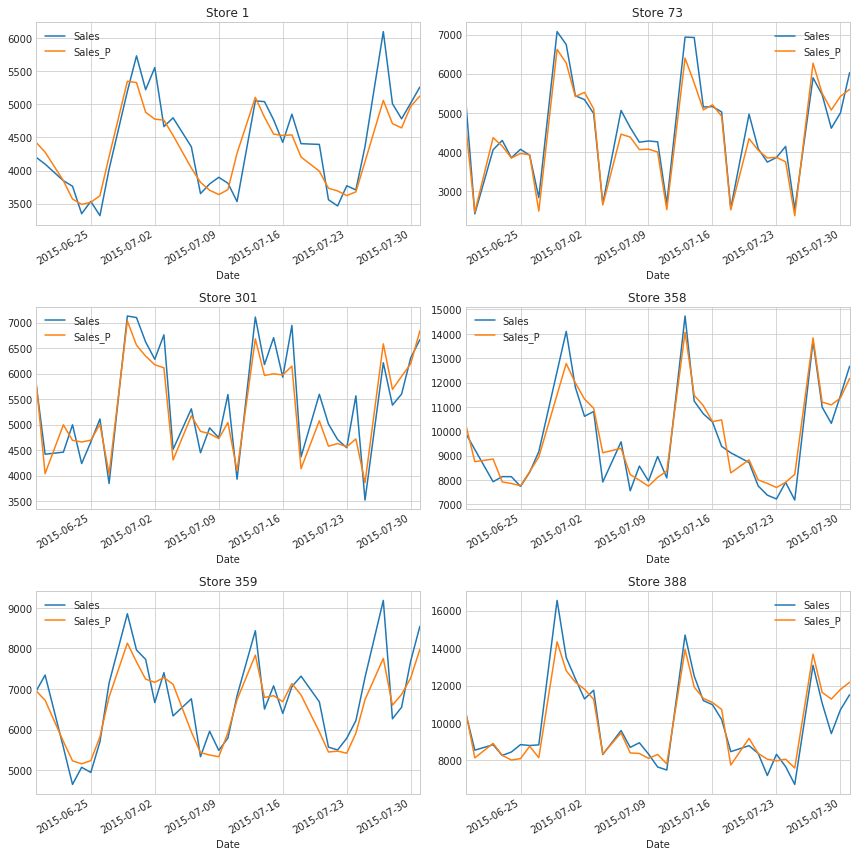

In [65]:
te_data['Sales_P'] = np.expm1(xgb_best.predict(X_test)).astype(int)
#te_data[['Store','Date','Sales','Sales_P']].head()
tmp_count = 0
fig,ax=plt.subplots(3,2,figsize=(12,12))
for index,group in te_data.groupby('Store'):
    if rmspe(group['Sales'],group['Sales_P']) > 0.07:
        continue
    tmp_count += 1
    group.set_index('Date',inplace=True,drop=False,verify_integrity=False)

    ax = plt.subplot(3,2,tmp_count)
    group[['Sales','Sales_P']].plot(ax=ax)
    tmp_title = 'Store '+str(index)
    ax.set_title(tmp_title)
    plt.legend(loc='best')
    
    if tmp_count > 5:
        break
        
plt.tight_layout()  

-----
### 对测试集数据进行预测，并提交至Kaggle获取评分

In [54]:
ypred_bst = xgb_best.predict(test_data[x_cols])
test_data['Id'] = test_data['Id'].astype(int)
test_data['Sales'] = (np.expm1(ypred_bst)).astype(int)
test_data[['Id','Sales']].to_csv('submission500.csv', index=False)
!kaggle competitions submit -c rossmann-store-sales -f submission500.csv -m "submission1-n500"

Successfully submitted to Rossmann Store Sales

In [55]:
xgb_best

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=13, min_child_weight=9, missing=None,
       n_estimators=500, n_jobs=16, nthread=None, objective='reg:linear',
       random_state=10, reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.95)

### 特征重要性排行

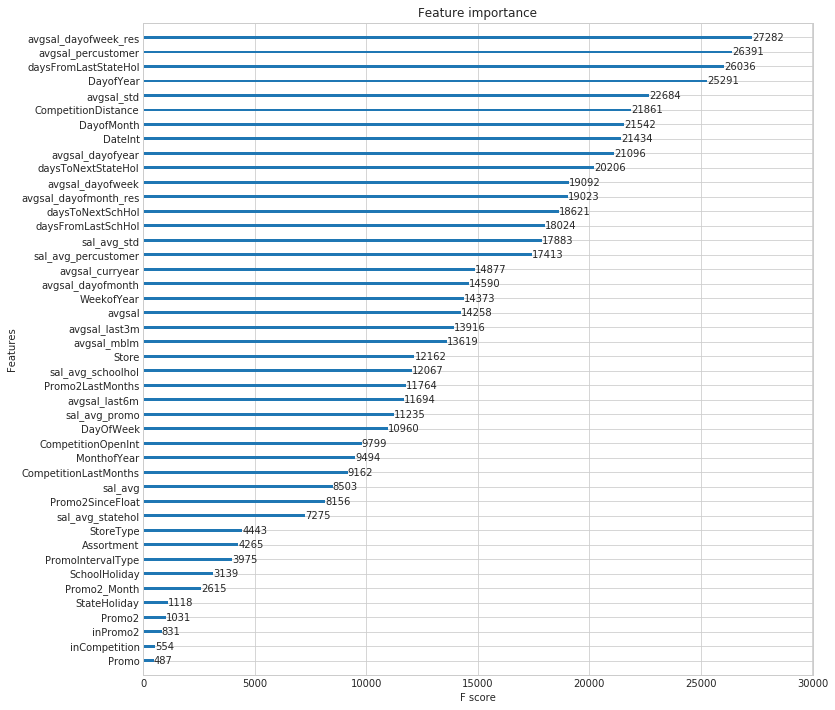

In [56]:
fig,ax=plt.subplots(figsize=(12,12))
xgb.plot_importance(xgb_best,ax=ax)

In [57]:
ypred_bst = xgb_best.predict(test_data[x_cols])
test_data['Id'] = test_data['Id'].astype(int)
test_data['Sales'] = (np.expm1(ypred_bst)*0.99).astype(int)
test_data[['Id','Sales']].to_csv('submission500_099.csv', index=False)
!kaggle competitions submit -c rossmann-store-sales -f submission500_099.csv -m "submission1-n500-099"

Successfully submitted to Rossmann Store Sales